In [1]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.inspection import permutation_importance

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

import warnings

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_wine
import optuna

In [2]:
# print input files
input_path = os.getcwd() + "/input"

In [3]:
# loading pizza data
data_path = input_path + "/pizza.csv"
pizza = pd.read_csv(data_path)

In [4]:
# clean up postal code
pizza['postalCode'] = pizza['postalCode'].astype(str)
pizza = pizza[pizza.postalCode != "nan"]
pizza = pizza[pizza["menus.amountMax"] < 100.0]
    
for i,j in enumerate(pizza['postalCode']):    
    # get rid of '-' postal code suffix
    if "-" in j:
        pizza['postalCode'][i] = pizza['postalCode'][i].split("-")[0]

/var/folders/0f/glct3g514dd7ylpg_7nb05c80000gn/T/ipykernel_24900/3576796121.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza['postalCode'][i] = pizza['postalCode'][i].split("-")[0]


In [5]:
# loading income data
data_path = input_path + "/income.csv"
income = pd.read_csv(data_path,engine='python',encoding='latin1')
income['Zip_Code'] = income['Zip_Code'].astype(str)
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15463 entries, 0 to 15462
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          15463 non-null  int64  
 1   State_Code  15463 non-null  int64  
 2   State_Name  15463 non-null  object 
 3   State_ab    15463 non-null  object 
 4   County      15463 non-null  object 
 5   City        15463 non-null  object 
 6   Place       15463 non-null  object 
 7   Type        15463 non-null  object 
 8   Primary     15463 non-null  object 
 9   Zip_Code    15463 non-null  object 
 10  Area_Code   15463 non-null  int64  
 11  ALand       15463 non-null  int64  
 12  AWater      15463 non-null  int64  
 13  Lat         15463 non-null  float64
 14  Lon         15463 non-null  float64
 15  Mean        15463 non-null  float64
 16  Median      15463 non-null  int64  
 17  Stdev       15463 non-null  object 
 18  Households  15463 non-null  int64  
dtypes: float64(3), int64(7), 

In [6]:
# join both datasets
pizza_df = pd.DataFrame(pizza)
pizza_df = pizza_df.set_index("postalCode")

income_df = pd.DataFrame(income[["Zip_Code", "Median"]])
income_df = income_df.set_index("Zip_Code")
complete_df = pizza_df.join(income_df, on='postalCode')

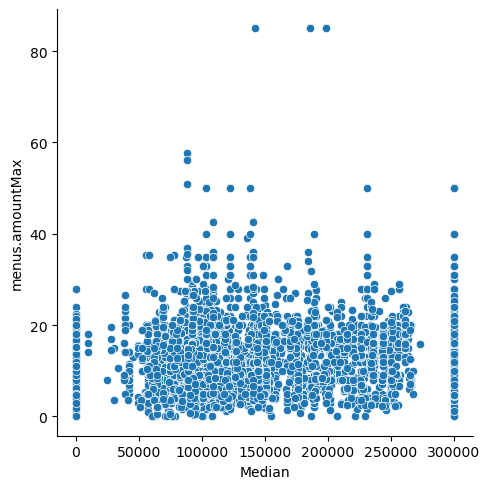

In [7]:
sns.relplot(data=complete_df, x=complete_df["Median"], y=complete_df["menus.amountMax"])

In [8]:
# find null values
print(complete_df.isnull().sum())

# find unique zipcodes in each dataframe
len(income_df.index.unique()), len(pizza_df.index.unique()), len(complete_df.index.unique())

# pizza zipcode covered in income zipcode
len(income_df.index.unique()), len(pizza_df.index.unique()), len(complete_df.index.unique())

id                       0
dateAdded                0
dateUpdated              0
address                  0
categories               0
primaryCategories        0
city                     0
country                  0
keys                     0
latitude                 0
longitude                0
menuPageURL           9477
menus.amountMax          0
menus.amountMin          0
menus.currency           0
menus.dateSeen           0
menus.description     7209
menus.name               0
name                     0
priceRangeCurrency       0
priceRangeMin            0
priceRangeMax            0
province                 0
Median                6864
dtype: int64


(11142, 1769, 1769)

In [9]:
# create master pipeline
data_pipeline = ColumnTransformer(
    transformers=[('imputer', SimpleImputer(strategy='mean'), ['Median']),
                  ('ord1', OrdinalEncoder(), ['province']),
                  ('ord2', OrdinalEncoder(), ['primaryCategories']),
                  ('ord3', OrdinalEncoder(), ['city']),],
    remainder='passthrough')
data_pipeline.set_output(transform="pandas")

df_processed = data_pipeline.fit_transform(complete_df)
df_processed.drop(columns=['remainder__menuPageURL','remainder__menus.description', 'remainder__id', 
                           'remainder__address', 'remainder__country', 'remainder__keys', 
                           'remainder__menus.currency', 'remainder__priceRangeCurrency', 'remainder__name',
                           'remainder__dateAdded', 'remainder__dateUpdated', 'remainder__menus.dateSeen'
                          ], inplace=True)
df_processed.drop(columns=['remainder__categories', 'remainder__menus.name',], inplace=True)
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11259 entries, 72120 to 89128
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   imputer__Median             11259 non-null  float64
 1   ord1__province              11259 non-null  float64
 2   ord2__primaryCategories     11259 non-null  float64
 3   ord3__city                  11259 non-null  float64
 4   remainder__latitude         11259 non-null  float64
 5   remainder__longitude        11259 non-null  float64
 6   remainder__menus.amountMax  11259 non-null  float64
 7   remainder__menus.amountMin  11259 non-null  float64
 8   remainder__priceRangeMin    11259 non-null  int64  
 9   remainder__priceRangeMax    11259 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 1.2+ MB


In [10]:
# split model
X, y = df_processed[df_processed.columns.difference(['remainder__menus.amountMax'])], df_processed[['remainder__menus.amountMax']]

X_train, X_rest, y_train, y_rest = train_test_split(
    X, y, test_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=42)

In [11]:
df_processed.head()


,imputer__Median,ord1__province,ord2__primaryCategories,ord3__city,remainder__latitude,remainder__longitude,remainder__menus.amountMax,remainder__menus.amountMin,remainder__priceRangeMin,remainder__priceRangeMax
postalCode,,,,,,,,,,
72120,93909.000000,2.0,0.0,866.0,34.832300,-92.183800,7.98,7.98,0,25
85012,142758.854152,3.0,0.0,716.0,33.509266,-112.073044,6.00,6.00,0,25
45209,142758.854152,30.0,0.0,169.0,39.144883,-84.432685,6.49,6.49,0,25
48071,142758.854152,19.0,0.0,524.0,42.516669,-83.106630,5.99,5.99,25,40
21224,142758.854152,18.0,0.0,63.0,39.286630,-76.566984,5.49,5.49,0,25


In [12]:
# Hyperparameter tuning
param_dist = {"max_depth": [3, 5], 
    "max_features": sp_randint(1, 11), 
    "min_samples_split": sp_randint(2, 11), 
    "bootstrap": [True, False], 
    "criterion": ['friedman_mse', 'poisson', 'absolute_error', 'squared_error']} 

rf = RandomForestRegressor()

# Randomized search
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
    n_iter=2, cv=2) 
random_search.fit(X_train, y_train.values.ravel())
hyperparams = random_search.best_params_

In [13]:
# train model
rf = RandomForestRegressor(**hyperparams)
rf.fit(X_val, y_val.values.ravel())

RandomForestRegressor(criterion='poisson', max_depth=5, max_features=8,
                      min_samples_split=3)

In [14]:
prediction = rf.predict(X_test)
r2_score(y_test, prediction)

0.8760055075382553

In [15]:
prediction = rf.predict(X_test)
mse = mean_squared_error(y_test, prediction)
rmse = mse**.5
print(mse)
print(rmse)


6.821317668909879
2.6117652400072022


In [16]:
df_processed['remainder__menus.amountMax'].describe()

count    11259.000000
mean        13.498888
std          7.027170
min          0.000000
25%          8.450000
50%         13.000000
75%         17.950000
max         88.000000
Name: remainder__menus.amountMax, dtype: float64

In [17]:
y_test_mean = [np.mean(y_test)]*len(y_test)
mse = mean_squared_error(y_test, y_test_mean)
rmse = mse**.5
print(mse)
print(rmse)

55.013069802389985
7.4170796006507835


/Users/Janice1/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


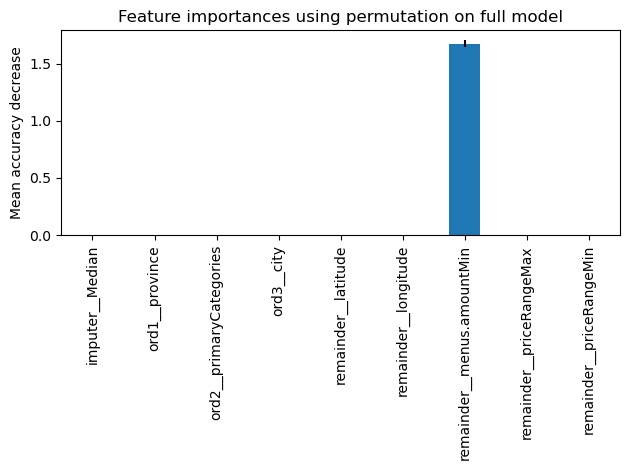

In [18]:
# determining feature importance 
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

# feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns
importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

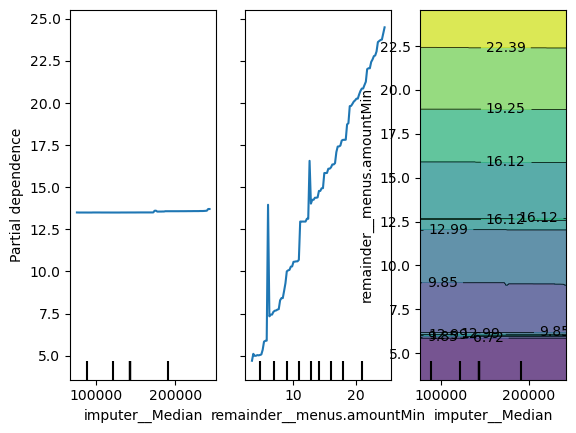

In [19]:
# plot partial dependency plot 
features = [0, 6, (0,6)]
PartialDependenceDisplay.from_estimator(rf, X, features)

In [20]:
# build second model with xg_boost
#hide warnings
warnings.filterwarnings('ignore')

model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [21]:
# R^2 value for xg_boost model
prediction = model.predict(X_test)
r2_score(y_test, prediction)

0.9041851918519612

In [31]:
# train new model without remainder_menus.amountMin
df_processed.drop(columns=['remainder__menus.amountMin',], inplace=True)

# split model
X, y = df_processed[df_processed.columns.difference(['remainder__menus.amountMax'])], df_processed[['remainder__menus.amountMax']]

X_train, X_rest, y_train, y_rest = train_test_split(
    X, y, test_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(
    X_rest, y_rest, test_size=0.5, random_state=42)

# train model
rf = RandomForestRegressor()
rf.fit(X_train, y_train.values.ravel())

prediction = rf.predict(X_val)
print(r2_score(y_val, prediction))

0.16120217254448632


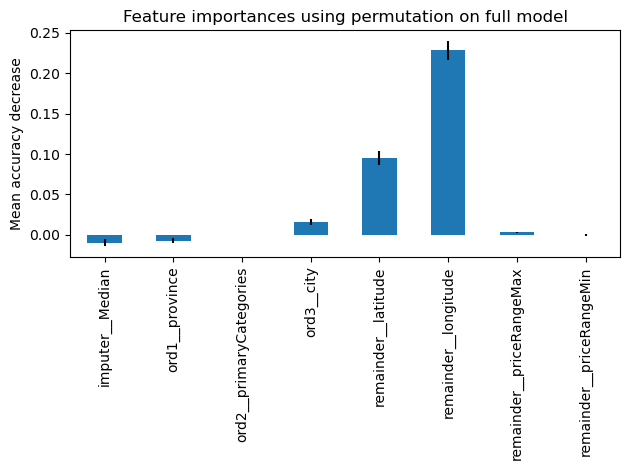

In [32]:
# determining feature importance 
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

# feature_names = [f"feature {i}" for i in range(X.shape[1])]
feature_names = X.columns
importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# shows that the model needs menu amountMin to have accurate prediction, or else it's dependent on it's coordinate 
# but it wasn't that accurate